In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 20, 10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense


In [93]:
# Load the dataset
df = pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


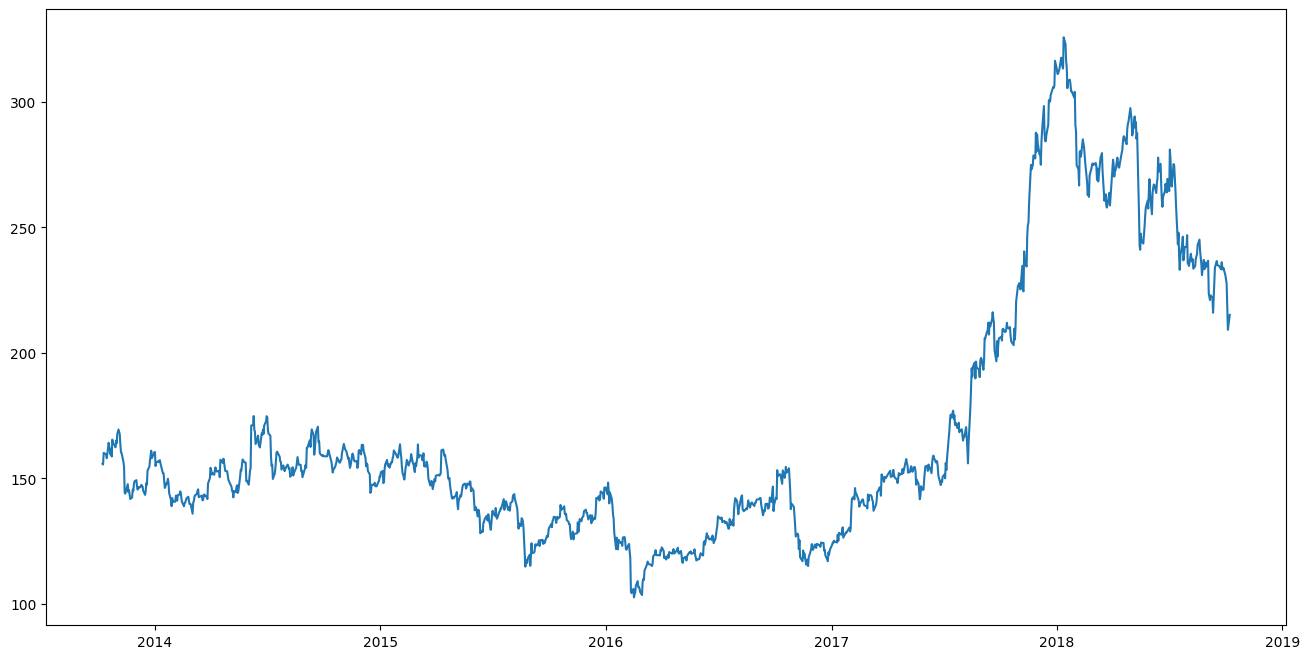

In [94]:
# Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df["Date"]

# Plotting the Close Price history
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label="Close Price history")

In [95]:
# Sorting the dataset
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=["Date", "Close"])

for i in range(0, len(data)):
    new_dataset["Date"][i] = data["Date"][i]
    new_dataset["Close"][i] = data["Close"][i]

# Setting the 'Date' column as index and dropping it
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)

/var/folders/87/tjt7p07109l38hkd0ypl896m0000gn/T/ipykernel_11512/3516567304.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i] = data["Date"][i]
/var/folders/87/tjt7p07109l38hkd0ypl896m0000gn/T/ipykernel_11512/3516567304.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` i

In [96]:
# Preparing the final dataset
final_dataset = new_dataset.values

# Splitting the dataset into training and validation sets
train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# Preparing the training data
x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60 : i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

x_train_data = np.reshape(
    x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1)
)

In [97]:
# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(
    LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1))
)
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

/Users/huypham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
# Compiling and fitting the model
lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

# Preparing the validation data
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60 :].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60 : i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

927/927 - 8s - 8ms/step - loss: 0.0010


In [99]:
# Making predictions
closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# Saving the model
lstm_model.save("saved_model.h5")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/87/tjt7p07109l38hkd0ypl896m0000gn/T/ipykernel_11512/1744987078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["Predictions"] = closing_price


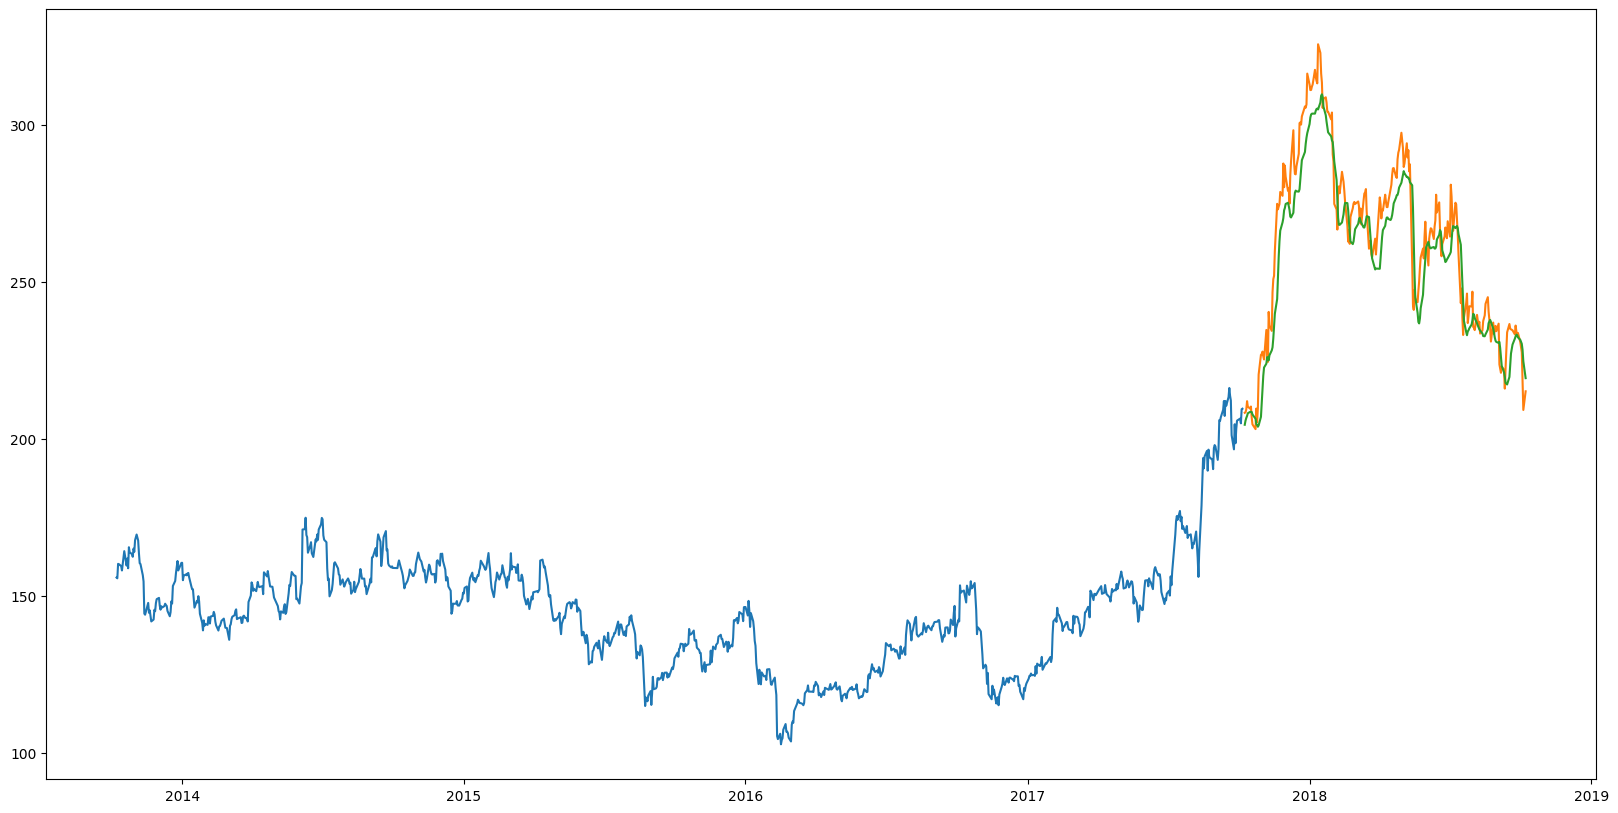

In [100]:
# Plotting the results
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data["Predictions"] = closing_price

plt.figure(figsize=(20, 10))
plt.plot(train_data["Close"], label='Train Data')
plt.plot(valid_data["Close"], label='Actual Price')
plt.plot(valid_data["Predictions"], label='Predicted Price')